In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qlib
from qlib.constant import REG_CN
qlib.init(provider_uri="~/.qlib/qlib_data/", region=REG_CN)

[3536:MainThread](2025-04-26 16:19:01,041) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[3536:MainThread](2025-04-26 16:19:02,119) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[3536:MainThread](2025-04-26 16:19:02,120) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/13574/.qlib/qlib_data')}


In [14]:
from qlib.data import D
import pandas as pd
# 获取指定时间范围内的日频交易日历
trade_dates = D.calendar(start_time='2000-01-01', end_time='2025-04-17')
# 定义指数代码
index_code = 'SH000300'
# 定义需要获取的字段
fields = ['$open', '$high', '$low', '$close', '$volume']
# 获取指数的历史数据
df = D.features([index_code], fields=fields, start_time='2000-01-05', end_time='2025-04-17', freq='day')
df.columns=['open', 'high', 'low', 'close', 'volume']
df = df.reset_index(level='datetime')
df['close_horizon'] = df['close'].shift(-5)
# 查看前几行数据
print(df.head())

             datetime      open      high       low     close        volume  \
instrument                                                                    
SH000300   2005-01-04  1.012185  1.012185  0.997827  1.000000  7.285323e+09   
SH000300   2005-01-05  0.998762  1.014783  0.997032  1.009941  6.996617e+09   
SH000300   2005-01-06  1.010721  1.011186  0.997493  1.000387  6.179837e+09   
SH000300   2005-01-07  1.000262  1.013149  0.996972  1.001191  7.173069e+09   
SH000300   2005-01-10  1.000988  1.011366  0.996947  1.011284  5.692017e+09   

            close_horizon  
instrument                 
SH000300         1.014601  
SH000300         1.014205  
SH000300         1.014337  
SH000300         1.005617  
SH000300         0.984391  


In [15]:
import pandas as pd

def add_technical_indicators(df):
    """
    给DataFrame加常用技术指标（MA, RSI, MACD, STD, MOM）
    要求df至少有: 'close', 'open', 'high', 'low', 'volume'列
    """
    df = df.copy()

    # 均线
    df['ma5'] = df['close'].rolling(window=5).mean()
    df['ma10'] = df['close'].rolling(window=10).mean()

    # 标准差（波动率）
    df['std5'] = df['close'].rolling(window=5).std()

    # 动量
    df['mom5'] = df['close'].diff(5)

    # RSI (14天)
    delta = df['close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    avg_gain = up.rolling(14).mean()
    avg_loss = down.rolling(14).mean()
    rs = avg_gain / (avg_loss + 1e-6)  # 避免除零
    df['rsi'] = 100 - (100 / (1 + rs))

    # MACD
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_diff'] = df['macd'] - df['macd_signal']

    # 记得丢掉有空值的行
    df = df.dropna().reset_index(drop=True)

    return df


In [16]:
# df原本只有: date, open, high, low, close, volume

df = add_technical_indicators(df)

print(df.columns)

Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'close_horizon',
       'ma5', 'ma10', 'std5', 'mom5', 'rsi', 'macd', 'macd_signal',
       'macd_diff'],
      dtype='object')


In [17]:
import math
def train_test_split(train_size, df):
    size = math.ceil(train_size * len(df))
    train_df = df.iloc[:size, :]
    test_df = df.iloc[size:, :]
    return train_df ,test_df

train_df, test_df = train_test_split(.7, df)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print("Traing Dataset info: ", train_df.shape)
print("Test Dataset info: ", test_df.shape)

Traing Dataset info:  (3436, 15)
Test Dataset info:  (1472, 15)


In [18]:
print(train_df.columns)

Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'close_horizon',
       'ma5', 'ma10', 'std5', 'mom5', 'rsi', 'macd', 'macd_signal',
       'macd_diff'],
      dtype='object')


In [49]:
from tqdm import tqdm
from DQN_agent import Agent
from DQN_enviorment import StockTradingEnv
tech_indicator_list = ['ma5', 'ma10', 'std5', 'mom5', 'rsi', 'macd', 'macd_signal', 'macd_diff']
episodes = 1

def Train_DQN(env: StockTradingEnv):
    agent = Agent(**agent_param)
    print('\nCollecting experience...')
    for i_episode in tqdm(range(episodes), desc="Training episode: "):
    # for i_episode in range(episodes):
        state = env.reset()  # 获得初始化 observation 环境特征
        ep_r = 0 # 作为一个计数变量，来统计我第n次训练。 完成所有动作的分的总和
        while True:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            # 存储数据  每完成一个动作，记忆存储数据一次
            agent.step(state, action, reward, next_state, done)
            ep_r += reward
            # 数据库中多于memory size时候就会学习
            if done:
                # 打印这是i_episode次训练, Ep_reward代表这次的总分
                # print('Ep: ', i_episode+1, '| Ep_reward: ', round(ep_r, 2))
                break
            state = next_state
    return agent


def Test_DQN(env_config, test_data: pd.DataFrame, agent):
    """
    :param env_config: dict
    :param test_data: trade data about test time
    :param agent: agent object
    """
    print("start predicting...")
    env = StockTradingEnv(test_data, **env_config)
    state = env.reset()
    ep_r = 0
    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        ep_r += reward
        if done:
            break
        state = next_state
    print(f'reward: {ep_r}')
    result = env.plot_df
    return result
random_list = [294, 185, 7, 300, 368, 724]

result = {}
for seed in random_list:
    torch.manual_seed(seed)
    np.random.seed(seed)
    agent_param = {
        "state_size": 8,
        "action_size": 3,
        'seed':0,
    }
    env_params = {
        "buy_cost_pct": 0.0005,
        "sell_cost_pct": 0.0005,
        "tech_indicator_list":tech_indicator_list,
        "seed": seed
    }

In [27]:
# reinforecement learning
train_env = StockTradingEnv(df = train_df, **env_params)
agent = Train_DQN(train_env)
res_df = Test_DQN(test_data=test_df, env_config=env_params, agent=agent)
# save result
result[f"seed_{seed}"] = res_df

Training episode: 100%|██████████| 1000/1000 [2:10:52<00:00,  7.85s/it] 


start predicting...
reward: 41.62529373168945


In [51]:
import pandas as pd
import numpy as np
import copy
from DQN_enviorment import Get_PosRet, Sharp_Ratio
# 假设你有 train_df, test_df
# train_df, test_df = ...


# 1. 训练多个随机种子的agent
random_list = [7, 42, 185, 294, 300, 368]
result = {}

for seed in random_list:
    np.random.seed(seed)  # 保证每次随机不同
    train_env = StockTradingEnv(df=train_df, **env_params)
    agent = Train_DQN(train_env)

    # 测试阶段，获取信号
    try:
        res_df = Test_DQN(test_data=test_df, env_config=env_params, agent=agent)
        result[f"seed_{seed}"] = res_df
    except Exception as e:
        print(f"Warning: seed_{seed} failed, skipping. Reason: {e}")

# 2. 把不同种子的预测信号整合
df = test_df[['datetime', 'close']].copy()  # 只要date和close
signal_col = []

for seed in random_list:
    key = f"seed_{seed}"
    if key in result:
        signal_col.append(key)
        df[key] = result[key]['signal']  # 把每个模型的signal加进来
    else:
        print(f"Warning: {key} not found in result, skipping.")

# 3. 投票融合不同agent的信号
if len(signal_col) == 0:
    raise ValueError("No valid signals found. Please check your training and testing.")

df['signal'] = df[signal_col].mode(axis=1)[0]  # 取众数作为最终信号

# 4. 根据最终信号计算持仓收益
df = Get_PosRet(df)

# 5. 计算基准收益（比如持有指数不交易）
df['benchmark'] = df['close'].pct_change()
df['cum_mkt'] = (1 + df['benchmark']).cumprod() - 1  # 基准累积收益
df['cum_strategy'] = (1 + df['return']).cumprod() - 1  # 策略累积收益

# 6. 打印/画图/保存结果
print("策略最终收益率：", df['cum_strategy'].iloc[-1])
print("基准最终收益率：", df['cum_mkt'].iloc[-1])
print("策略夏普比率：", Sharp_Ratio(df['return']))




Training episode: 100%|██████████| 1/1 [00:08<00:00,  8.05s/it]


start predicting...
reward: 41.62529373168945



Training episode: 100%|██████████| 1/1 [00:07<00:00,  7.64s/it]


start predicting...
reward: 41.62529373168945



Training episode: 100%|██████████| 1/1 [00:07<00:00,  7.72s/it]


start predicting...
reward: 41.62529373168945



Training episode: 100%|██████████| 1/1 [00:07<00:00,  7.77s/it]


start predicting...
reward: 41.62529373168945



Training episode: 100%|██████████| 1/1 [00:07<00:00,  7.80s/it]


start predicting...
reward: 41.62529373168945



Training episode: 100%|██████████| 1/1 [00:07<00:00,  7.60s/it]


start predicting...
reward: 41.62529373168945
策略最终收益率： 0.0
基准最终收益率： -0.030281067
策略夏普比率： nan


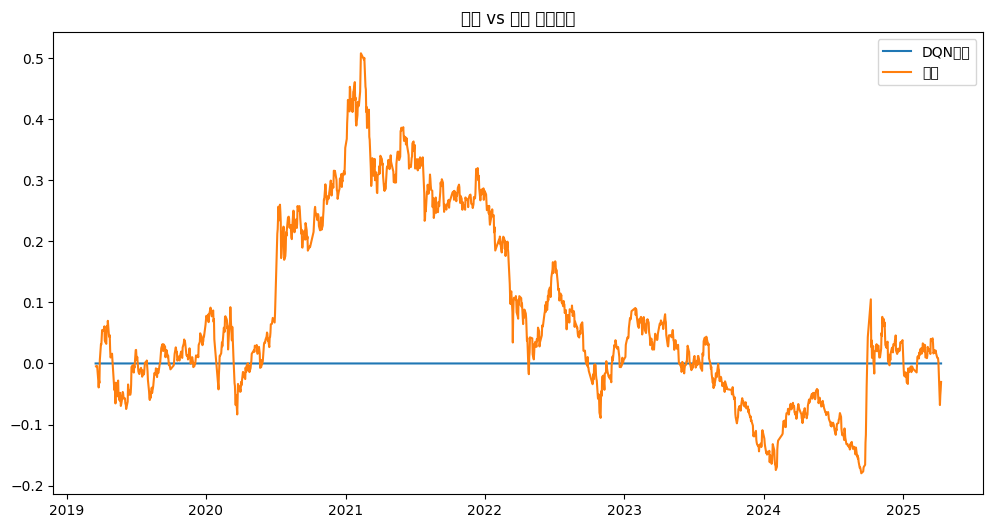

In [52]:
# 如果要画收益曲线
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['datetime'], df['cum_strategy'], label="DQN策略")
plt.plot(df['datetime'], df['cum_mkt'], label="基准")
plt.legend()
plt.title("策略 vs 基准 收益曲线")
plt.show()

In [53]:
# 工具1：计算年化夏普比率
def Annual_Sharpe_Ratio(daily_returns, trading_days=252):
    mean_return = daily_returns.mean()
    std_return = daily_returns.std()
    sharpe_ratio = (mean_return / std_return) * np.sqrt(trading_days)
    return sharpe_ratio

# 工具2：最大回撤计算
def Max_Drawdown(cum_returns):
    roll_max = cum_returns.cummax()
    drawdown = (cum_returns - roll_max) / roll_max
    max_drawdown = drawdown.min()
    return max_drawdown

# 工具3：年度回测总结
def Yearly_Performance(df):
    df['year'] = pd.to_datetime(df['datetime']).dt.year

    result = []

    for year in df['year'].unique():
        temp = df[df['year'] == year]
        year_return = (temp['cum_strategy'].iloc[-1] + 1) / (temp['cum_strategy'].iloc[0] + 1) - 1
        benchmark_return = (temp['cum_mkt'].iloc[-1] + 1) / (temp['cum_mkt'].iloc[0] + 1) - 1
        sharpe = Annual_Sharpe_Ratio(temp['return'])
        mdd = Max_Drawdown(temp['cum_strategy'] + 1)  # 注意累积收益+1后计算

        result.append({
            'Year': year,
            'Strategy Return': round(year_return * 100, 2),
            'Benchmark Return': round(benchmark_return * 100, 2),
            'Strategy Sharpe': round(sharpe, 2),
            'Max Drawdown': round(mdd * 100, 2)
        })

    result_df = pd.DataFrame(result)
    return result_df

# --- 刚才的流程之后，加上这一段 ---

# 年度回测总结表
yearly_result = Yearly_Performance(df)
print("\n📈 年度回测表现：")
print(yearly_result)

# 如果想保存
# yearly_result.to_csv("yearly_performance.csv", index=False)



📈 年度回测表现：
   Year  Strategy Return  Benchmark Return  Strategy Sharpe  Max Drawdown
0  2019              0.0               NaN              NaN           0.0
1  2020              0.0             25.51              NaN           0.0
2  2021              0.0             -6.21              NaN           0.0
3  2022              0.0            -21.27              NaN           0.0
4  2023              0.0            -11.75              NaN           0.0
5  2024              0.0             16.20              NaN           0.0
6  2025              0.0             -2.23              NaN           0.0


In [54]:
print(df[['datetime', 'return', 'cum_strategy', 'cum_mkt']].head(20))


     datetime  return  cum_strategy   cum_mkt
0  2019-03-18     0.0           0.0       NaN
1  2019-03-19     0.0           0.0 -0.004619
2  2019-03-20     0.0           0.0 -0.004234
3  2019-03-21     0.0           0.0 -0.003858
4  2019-03-22     0.0           0.0 -0.004660
5  2019-03-25     0.0           0.0 -0.028278
6  2019-03-26     0.0           0.0 -0.039284
7  2019-03-27     0.0           0.0 -0.028133
8  2019-03-28     0.0           0.0 -0.032025
9  2019-03-29     0.0           0.0  0.005346
10 2019-04-01     0.0           0.0  0.031721
11 2019-04-02     0.0           0.0  0.031035
12 2019-04-03     0.0           0.0  0.044242
13 2019-04-04     0.0           0.0  0.054645
14 2019-04-08     0.0           0.0  0.053347
15 2019-04-09     0.0           0.0  0.058072
16 2019-04-10     0.0           0.0  0.060777
17 2019-04-11     0.0           0.0  0.037861
18 2019-04-12     0.0           0.0  0.035534
19 2019-04-15     0.0           0.0  0.032133


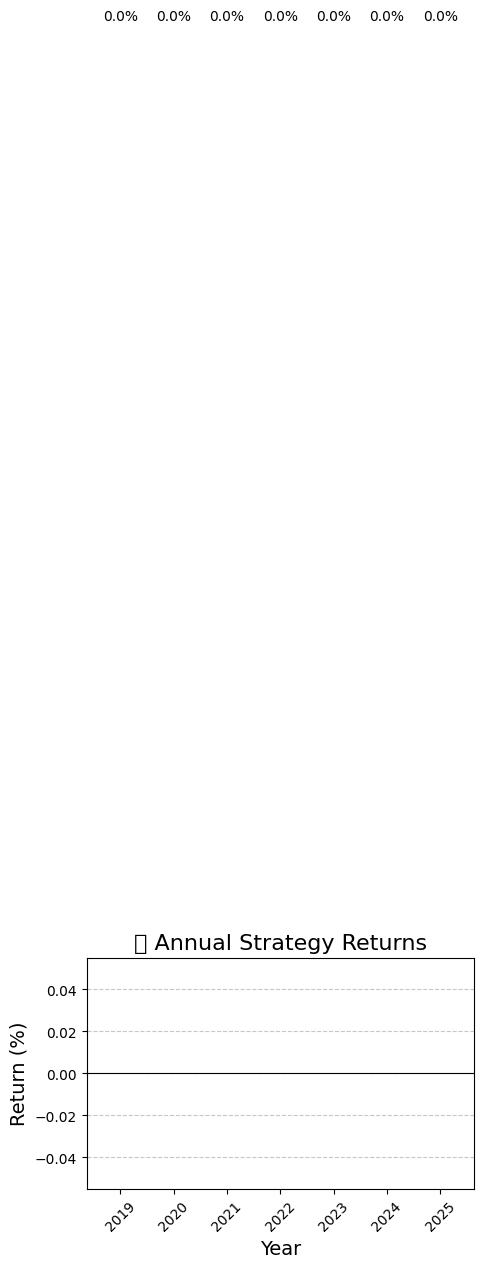

In [55]:
import matplotlib.pyplot as plt

def Plot_Yearly_Returns(yearly_result):
    plt.figure(figsize=(5,3))

    # 获取数据
    years = yearly_result['Year']
    returns = yearly_result['Strategy Return']

    # 涨的用红色，跌的用绿色
    colors = ['red' if r >= 0 else 'green' for r in returns]

    bars = plt.bar(years, returns, color=colors, width=0.6)

    # 添加数值标签
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + (0.5 if yval >=0 else -2),
                 f'{yval:.1f}%', ha='center', va='bottom' if yval>=0 else 'top', fontsize=10)

    plt.axhline(0, color='black', linewidth=0.8)  # 加一条横线表示0%
    plt.title('📊 Annual Strategy Returns', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Return (%)', fontsize=14)
    plt.xticks(years, rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
Plot_Yearly_Returns(yearly_result)